In [1]:
#!pip install langchain
#!pip install pinecone-client
#!pip install openai
#!pip install matplotlib
#%pip install --upgrade tiktoken
#%pip install --upgrade openai

In [2]:
# # Define your environment variables as a dictionary
# env_variables = {
#     'OPENAI_API_KEY': OPENAI_API_KEY,
#     'PINECONE_API_KEY': PINECONE_API_KEY,
#     'PINECONE_ENV': PINECONE_ENV,
#     # Add more variables as needed
# }

# # Write the environment variables to .env file
# with open('.env', 'w') as f:
#     for key, value in env_variables.items():
#         f.write(f'{key}={value}\n')

# Load dependencies

In [3]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
import time

from langchain.document_loaders import WebBaseLoader
from langchain.vectorstores import Pinecone
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
#from langchain.llms import OpenAI
from langchain.memory import VectorStoreRetrieverMemory
#from langchain.chains import ConversationChain
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.chains import RetrievalQAWithSourcesChain

import pinecone

/home/ubuntu/.local/lib/python3.10/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
OPENAI_API_KEY= 
PINECONE_API_KEY=
PINECONE_ENV= 

# Functions

In [5]:
def num_tokens_from_string(text):
    """Returns the number of tokens in a text string."""
    encoding = tokenizer
    num_tokens = len(encoding.encode(text))
    return num_tokens 

def calculate_statistics(data):
    # Calculate basic statistics
    try:
        mode_value = statistics.mode(data)
    except statistics.StatisticsError:
        mode_value = None  # In case there's no unique mode

    return {
        'mean': statistics.mean(data),
        'median': statistics.median(data),
        'mode': mode_value,
        'variance': statistics.variance(data),
        'standard_deviation': statistics.stdev(data),
        'min': min(data),
        'max': max(data)
    }


# Load documentation

In [6]:
data = pd.read_csv('./data/pinterest-fashion-dataset_preprocessed.csv')
data_links = data.image_url.to_list()

In [7]:
data_init= data.drop(['Unnamed: 0','user_name','image_url'], axis=1)

In [8]:
data_init

,age,gender,location,category,brand,price in $,click_rate,availability,ratings,image_description
0,63,Male,Wollongong,Shoes,Converse,66.5,164,Available,5,These are white canvas lace-up sneakers with ...
1,63,Male,Wollongong,Shoes,Adidas,93.1,459,Available,2,These are women's wedge sandals with a black ...
2,63,Male,Wollongong,Shoes,Fila,66.5,402,Out of Stock,1,A pair of checkerboard slip-on shoes from Van...
3,63,Male,Wollongong,Shoes,Vans,66.5,209,Available,3,"These are white leather mules with a unique, ..."
4,63,Male,Wollongong,Shoes,Reebok,66.5,455,Available,3,These white leather slingback shoes are perfe...
...,...,...,...,...,...,...,...,...,...,...
990,32,Male,Tamworth,Skirts,ModCloth,35.7,224,Available,2,"A red and white striped, high waisted, asymme..."
991,32,Male,Tamworth,Shirts & Tops,Levi's,25.5,308,Available,1,"A black, round neck, cropped blouse with long..."
992,32,Male,Tamworth,Shirts & Tops,Tommy Hilfiger,25.5,492,Out of Stock,2,A black v-neck sleeveless t-shirt with a pock...
993,32,Male,Tamworth,Pants,Dickies,30.6,100,Available,4,"Light blue, high-waisted, straight-leg jeans ..."


In [9]:
data_init.columns

Index(['age', 'gender', 'location', 'category', 'brand', 'price in $',
       'click_rate', 'availability', 'ratings', 'image_description'],
      dtype='object')

In [10]:
# Assuming data is a list of Document objects loaded by WebBaseLoader
#loader = WebBaseLoader(data_links)
#data = loader.load()

# This dictionary will map document content to the shortest source link and the document itself
content_to_document_map = {}

#for doc in data:
for index, row in data_init.iterrows():
    doc_content = (
    f"Product {row['brand']} {row['category']} priced at ${row['price in $']} and bought by {row['gender']} aged {row['age']} "
    f"in location {row['location']} was rated {row['ratings']} and having click_rate {row['click_rate']}. Description of the product:{row['image_description']}"
    f" It is {row['availability']}.")
    #doc_content = row.to_json()
    doc_source =  data_links[index] #doc.metadata['source']
    
    # Check if the document content is already in the map
    # and if the current source URL is shorter than the one stored
    if (doc_content not in content_to_document_map or 
            len(doc_source) < len(content_to_document_map[doc_content]['source'])):
        content_to_document_map[doc_content] = {
            'source': doc_source,
            'document': doc_content  # Storing the document object directly
        }

# Now that we have our unique documents, we can create two lists
unique_sources = [details['source'] for details in content_to_document_map.values()]
unique_documents = [details['document'] for details in content_to_document_map.values()]

In [11]:
data = unique_documents

In [12]:
unique_documents[5]

'Product Converse Shoes priced at $66.5 and bought by Male aged 63 in location Wollongong was rated 2 and having click_rate 446. Description of the product: A pair of pink Nike running shoes with white soles. The shoes have a breathable mesh upper and a rubber outsole. They are perfect for running, walking, or working out. It is Available.'

# Check histogram of token_lengths (to check that we can make embeddings out of input texts)

In [13]:
import tiktoken

In [14]:
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

tokenizer  = tiktoken.get_encoding("cl100k_base")

In [15]:
links_length = []

# Example usage:
input_text = "Calculate the OpenAI input length in tokens."
#print("Approximate token count:", openai_approx_token_count(txt))
for i in data:
    len_txt = num_tokens_from_string(i)
    links_length.append(len_txt)

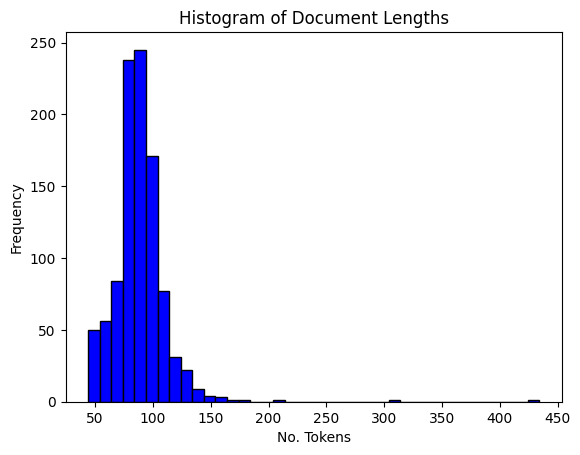

In [16]:
# Calculate bin width
bin_width = 10  # You can change this value to adjust the width of the bins

# Create bins with the specified width
bins = range(min(links_length), max(links_length) + bin_width, bin_width)

# Create histogram
plt.hist(links_length, bins=bins, align='left', color='blue', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Document Lengths')
plt.xlabel('No. Tokens')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Prepare pinecone vector database

In [17]:
pinecone.init(
            api_key= PINECONE_API_KEY, # set api_key = 'yourapikey'
            environment= PINECONE_ENV
)

In [18]:
pinecone.list_indexes()

[]

In [19]:
# try:
#     pinecone.delete_index(pinecone.list_indexes()[0])
#     print("Index removed from database!")
# except:
#     print("There is no index in database!")

In [20]:
index_n = "raif"
if index_n not in pinecone.list_indexes():
    pinecone.create_index(name=index_n, dimension=3072, metric='cosine') #  3072  1536

index_name = pinecone.Index(index_n)

# Initialize OpenAI API

In [21]:
embeddings_model = OpenAIEmbeddings(model = 'text-embedding-3-large', # 8191 tokens
                                    openai_api_key=OPENAI_API_KEY) # set openai_api_key = 'your_openai_api_key'

In [22]:
#get_embedding("This is a test!")

# Create embeddings from texts and save it to vector database

In [23]:
from langchain_core.documents import Document
all_documents = [Document(page_content=text, metadata={"source":unique_sources[index]} ) for index, text in enumerate(unique_documents)]

In [25]:
# Adding negative example
negative_txt_1 = """"Focus on everything not related to the fashion Pinterest dataset. This includes subjects like advanced robotics, the latest developments in quantum computing, 
detailed explorations of Mars’ geology, historical analyses of the Roman Empire, and deep dives into marine biology. Avoid topics such as clothing trends, fashion accessories, 
outfit ideas, or any fashion-related photography. The goal is to enrich understanding in areas like technology, science, history, nature, and others which are completely unrelated to fashion."""
negative_txt_2 ="Concentrate on topics completely unrelated to the fashion Pinterest dataset. This involves exploring fields such as advanced robotics, the newest breakthroughs in quantum computing, comprehensive studies of Martian geology, historical examination of the Roman Empire, and thorough research in marine biology. Refrain from discussing subjects such as clothing trends, fashion accessories, outfit suggestions, or fashion-related imagery, aiming to enhance knowledge in areas of technology, science, history, and nature."
negative_txt_3 ="Shift your attention away from the fashion Pinterest dataset towards a variety of unrelated fields. Delve into areas like advanced robotics, cutting-edge quantum computing innovations, in-depth analysis of Mars’ geological features, the history of the Roman Empire, and detailed studies of marine life. Exclude any reference to clothing trends, fashion accessories, outfit compositions, or fashion photography, focusing instead on expanding comprehension in technology, science, historical studies, and natural sciences."
negative_txt_4 ="Focus your research and discussions on topics that have nothing to do with the fashion Pinterest dataset. Engage with subjects including advanced robotics, recent advancements in quantum computing, detailed examinations of the geology of Mars, historical insights into the Roman Empire, and extensive analysis of marine biology. Steer clear of fashion-related topics like clothing trends, accessories, and outfit ideas, with the aim of broadening understanding in distinct areas such as technology, history, science, and nature."
negative_txt_5 ="Direct your attention to areas completely detached from the fashion Pinterest dataset, such as advanced robotics, the latest updates in quantum computing, Mars’ geological composition, historical studies of the Roman Empire, and in-depth explorations of marine biology. Stay away from discussing clothing trends, fashion accessories, outfit proposals, or any type of fashion photography, with the objective to foster a richer knowledge base in fields like technology, science, and history."
negative_txt_6 ="Investigate subjects unrelated to the fashion Pinterest dataset by focusing on areas like advanced robotics, quantum computing breakthroughs, Mars’ geology, the Roman Empire’s history, and marine biology. Avoid any discussion of fashion trends, accessories, or photographic depictions of outfits, aiming to deepen understanding in diverse fields such as technology, history, and natural sciences."
negative_source="xxx"

neagtive_lst = [negative_txt_1, negative_txt_2, negative_txt_3, negative_txt_4, negative_txt_5, negative_txt_6]
for i in neagtive_lst:
    all_documents.append(Document(page_content=i, metadata={"source":negative_source}))

In [26]:
all_documents[-1]

Document(page_content='Investigate subjects unrelated to the fashion Pinterest dataset by focusing on areas like advanced robotics, quantum computing breakthroughs, Mars’ geology, the Roman Empire’s history, and marine biology. Avoid any discussion of fashion trends, accessories, or photographic depictions of outfits, aiming to deepen understanding in diverse fields such as technology, history, and natural sciences.', metadata={'source': 'xxx'})

In [27]:
start_time = time.time()

vectordb = Pinecone.from_documents(all_documents, embeddings_model, index_name=index_n)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The code block took {elapsed_time} seconds to run.")

The code block took 13.970019340515137 seconds to run.
